# 2. Introduction to msprime

1. Why use msprime?
2. Getting started
3. Recombination
4. Mutation
5. Population structure
6. Demographic events
7. Large simulations
8. Exporting to other data formats

## 2.1 Why use msprime?

This notebook introduces `msprime` [[1](https://msprime.readthedocs.io/en/stable/introduction.html)], an reimplementation of Hudson's `ms` program [[2](http://home.uchicago.edu/~rhudson1/source/mksamples.html)] for simulating genomic datasets under the coalescent model with recombination. Because it simulates datasets with the tree sequence structure, `msprime` is much more computationally efficient than many other simulation softwares. We will see that it can easily simulate chromosome-sized regions for hundreds of thousands of samples.
 
In later workshops, we will show how simulations with `msprime` can be used to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance.
 
### The coalescent model with recombination
 
 Blurby summary of what the coalescent model is.
 Maybe put some freely available references here (Graham Coop's book, for example?)? Or, could make a picture?
 
 some important assumptions:
 - infinite sites
 - infinite times
 - small sample size relative to population
 - No selection
 
### Other references

[1] Kelleher, J., Etheridge, A. M., & McVean, G. (2016). Efficient Coalescent Simulation and Genealogical Analysis for Large Sample Sizes. PLOS Computational Biology, 12(5), e1004842. https://doi.org/10.1371/journal.pcbi.1004842

[2] Hudson, R. R. (2002) Generating samples under a Wright-Fisher neutral model. Bioinformatics 18:337-8.

## 2.2 Getting started

In [1]:
import msprime
from IPython.display import SVG

### A simple simulation

 The minimal input into msprime is a sample size. Let's simulate a small sample of 6 chromosomes to start off with. We'll use this to illustrate some basic features of msprime simulations.

In [2]:
ts = msprime.simulate(sample_size = 6, random_seed = 1)

Number of trees in tree sequence: 1
Length of simulated sequence: 1.0


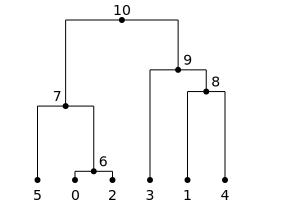

In [3]:
print("Number of trees in tree sequence:", ts.num_trees)
print("Length of simulated sequence:", ts.sequence_length)
display(SVG(ts.first().draw(width=300)))

Notice that there is only a single tree in our simulated tree sequence. This is because we have not specified any recombination. 
Because we also haven't specified a sequence length, our simulated sequence will have length 1. 
The units of genomic length in msprime are arbitrary, but it is often convenient to specify the length to be the number of nucleotide bases in the sequence.

In [4]:
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	1	0	-1	0.00000000000000	
6	0	0	-1	0.07194744353492	
7	0	0	-1	0.61124301112428	
8	0	0	-1	0.73124726040958	
9	0	0	-1	0.91078323219376	
10	0	0	-1	1.32301250012150	


The six simulated sample nodes are the ones labelled 0 - 5. Their 'sample' status is indicated by the flags column.

### Times in msprime

In msprime, times are given in units of *generations backwards-in-time* (not in coalescent units of 2Ne, as in some other coalescent simulation softwares).

The reason why the node times in our simple example are so small is because, by default, msprime assumes a constant effective population size N of 1.
Recall that under the coalescent model, each simulated ancestral node represents a *coalescence event* at which two lineages converge. These coalescences should occur less frequently in a larger population. We can see this by specifying a bigger population size in our simulation:

In [5]:
ts = msprime.simulate(sample_size = 6, random_seed = 1, Ne = 10000)
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	1	0	-1	0.00000000000000	
6	0	0	-1	719.47443534915067	
7	0	0	-1	6112.43011124283566	
8	0	0	-1	7312.47260409581213	
9	0	0	-1	9107.83232193760159	
10	0	0	-1	13230.12500121500307	


### Random seeds

In general, running the same `msprime` commands multiple times will produce different outputs.
To ensure the same output, you can specify a random seed. 

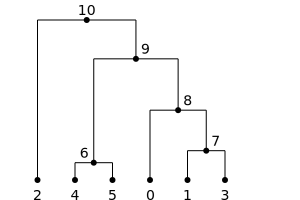

In [6]:
ts = msprime.simulate(sample_size = 6, random_seed = 10)

for tree in ts.trees():
    display(SVG(tree.draw(width=300)))

## 2.3 Recombination

With `msprime`, we can simulate not just a single genomic locus, but entire chromosomal-sized sequences. 
To do this, we will often want to add in a model of recombination.

### Uniform recombination

To simulate with a constant recombination rate, we must specify two extra inputs to `msprime.simulate`: a sequence length (most easily specified as a number of bases) and a recombination rate (specified as the rate of crossing over per unit of length per generation).

Tree on interval (0.0, 181.74732201307717)


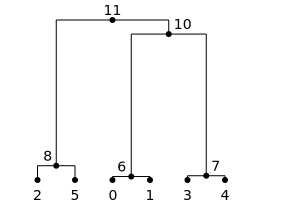

Tree on interval (181.74732201307717, 1000.0)


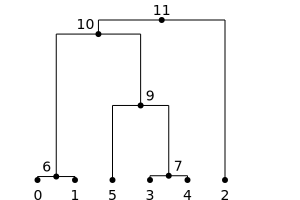

In [7]:
ts = msprime.simulate(sample_size = 6, random_seed = 12, length = 1000, recombination_rate = 1e-4 )

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

A consequence of the infinite sites assumption is that crossovers will occur at non-integer locations. 

### Non-uniform recombination

It's also possible to simulate under a variable rate of recombination.
To do this, specify an external recombination map given as a `msprime.RecombinationMap` object.
See the [msprime documentation](https://msprime.readthedocs.io/en/stable/api.html?highlight=RecombinationMap#msprime.RecombinationMap) for more information about these objects.

In [8]:
# Making a RecombinationMap object.
map_positions = [i*100 for i in range(0, 11)]
map_rates = [0, 1e-4, 5e-4, 1e-4, 0, 0, 0, 5e-4, 6e-4, 1e-4, 0]
my_map = msprime.RecombinationMap(map_positions, map_rates)

# Simulating with the recombination map.
ts = msprime.simulate(sample_size = 6, random_seed = 12, recombination_map = my_map)
# for tree in ts.trees():
#     print('Tree on interval', tree.interval)
#     display(SVG(tree.draw(width=300)))

### Integer crossover breakpoints

Get help from Jerome on this.

In [9]:
# map_positions = [i*100 for i in range(0, 11)]
# map_rates = [0, 1e-4, 5e-4, 1e-4, 0, 0, 0, 5e-4, 6e-4, 1e-4, 0]
# my_map = msprime.RecombinationMap(map_positions, map_rates, num_loci = 1000)

# ts = msprime.simulate(sample_size = 6, random_seed = 12, recombination_map = my_map)
# for tree in ts.trees():
#     print(tree.interval)

## 2.4 Mutation

Per base mutation rate.

Tree on interval (0.0, 181.74732201307717)


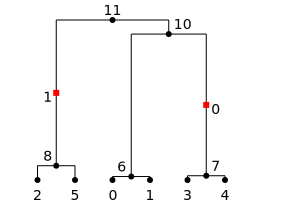

Tree on interval (181.74732201307717, 1000.0)


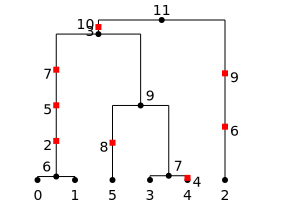

In [10]:
ts = msprime.simulate(sample_size = 6, random_seed = 12,
                     length = 1000, recombination_rate = 1e-4,
                     mutation_rate = 7e-4)

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

In [11]:
print(ts.tables.mutations)

id	site	node	derived_state	parent	metadata
0	0	7	1	-1	
1	1	8	1	-1	
2	2	6	1	-1	
3	3	10	1	-1	
4	4	4	1	-1	
5	5	6	1	-1	
6	6	2	1	-1	
7	7	6	1	-1	
8	8	5	1	-1	
9	9	2	1	-1	


Can be iterated through 1 at a time:

In [12]:
for var in ts.variants():
    print(var.genotypes)

[0 0 0 1 1 0]
[0 0 1 0 0 1]
[1 1 0 0 0 0]
[1 1 0 1 1 1]
[0 0 0 0 1 0]
[1 1 0 0 0 0]
[0 0 1 0 0 0]
[1 1 0 0 0 0]
[0 0 0 0 0 1]
[0 0 1 0 0 0]


Or all at once (though, this can be very big)

In [13]:
ts.genotype_matrix()

array([[0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0]], dtype=uint8)

## 2.5 Populations and population structure

### PopulationConfiguration objects

## 2.6 Demographic events

### Migrations

### Population size changes

### Using the Demography Debugger

## 2.7 Large simulations

### Replicate simulations

## 2.8 Exporting data into other formats